![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)


## 1. Get the Data

You can find the data at this Google Drive URL (NPZ format)

https://drive.google.com/file/d/1-OplAg9THXuzKC_oYAiB4wdBmCTdiy4z/view?usp=sharing <br>
https://drive.google.com/file/d/1-Svi93L-C7qAq2oJmtajfCJDjGdJTIaE/view?usp=sharing <br>
https://drive.google.com/file/d/1-Dpozh1KCEvuCYgYuaf98-PzHhHTo3F_/view?usp=sharing <br>


If working at colab, mount Google Drive:

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

## 2. Libraries

To begin, let's load those libraries that we need

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os

from tensorflow import keras as ks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


## 3. Defining some constants

In [3]:
IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# We define the path where you have the NPZ files
path = ""

## 4. We prepare the training data

We will load them in the NPZ format that we discussed in the last class

In [4]:
dict_npz = np.load(path+'xy_train_img.npz')
x_train_img = dict_npz['x']
y_train_img = dict_npz['y']

dict_npz = np.load(path+'xy_test_img.npz')
x_test_img = dict_npz['x']
y_test_img = dict_npz['y']

dict_npz = np.load(path+'xy_val_img.npz')
x_val_img = dict_npz['x']
y_val_img = dict_npz['y']

x_train_scaled = x_train_img / 255.
x_test_scaled = x_test_img / 255.
x_val_scaled = x_val_img / 255.

In [5]:
print("Shape X train:", x_train_scaled.shape)
print("Shape Y train:", y_train_img.shape)

print("Shape X test:", x_test_scaled.shape)
print("Shape Y test:", y_test_img.shape)

print("Shape X val:", x_val_scaled.shape)
print("Shape Y val:", y_val_img.shape)



Shape X train: (5000, 150, 150, 3)
Shape Y train: (5000,)
Shape X test: (1000, 150, 150, 3)
Shape Y test: (1000,)
Shape X val: (1000, 150, 150, 3)
Shape Y val: (1000,)


## 5. Explore the data

<AxesSubplot:>

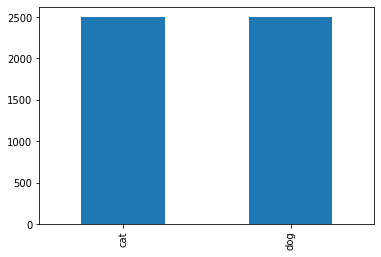

In [6]:
df_train = pd.DataFrame(y_train_img, columns=['category'])
df_train['category'].value_counts().plot.bar()

As we can see we have 2500 examples of each class ... a little to be a neural network for computer vision ... you will see ...

## 6. Lets see an image

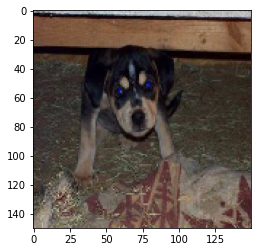

In [7]:
sample = random.choice(range(0,4999))
image = x_train_scaled[sample]
plt.imshow(image, cmap=plt.cm.binary)

## 7. Let's stack blocks to make the model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

In [8]:
model = ks.Sequential()

model.add(ks.layers.Conv2D(16, (3, 3), activation='relu', 
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(ks.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(ks.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(ks.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.3))
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.3))
model.add(ks.layers.Dense(1, activation='sigmoid')) # 1 of output as the target is binary (0 or 1)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

## 8. Let's compile the model

In [9]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

## 9. Let's define a callback for early stopping

**Early Stopping**

We prevent overfitting by stopping when after 10 epochs and the validation error does not decrease (we are in a plateau)

In [10]:
callback_val_loss = EarlyStopping(monitor="val_loss", patience=5)
callback_val_accuracy = EarlyStopping(monitor="val_accuracy", patience=10)

## 10. Prepare the data


We will do a one-hot encoding that will be good for our classification

In [11]:
y_train_img

array(['cat', 'cat', 'cat', ..., 'dog', 'dog', 'dog'], dtype='<U3')

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train_img)
y_train_encoded = le.transform(y_train_img)
y_val_encoded = le.transform(y_val_img)
y_test_encoded = le.transform(y_test_img)

In [13]:
y_train_encoded

array([0, 0, 0, ..., 1, 1, 1])

## 11. Transformer from images to consumable data for the neural network

**Train data**

Here we will include our image generation part (with starting code)

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
    )

train_generator = train_datagen.flow(
    x_train_img,  # Aquí hay que usar datos NO re-escalados... de ahi que no usemos x_train_rescaled!
    y_train_encoded, 
    batch_size=50
)

**Validation (test does not need it)**

Note that here the only modification is a rescaling, no modifications

In [15]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
    )
validation_generator = validation_datagen.flow(
    x_val_img, 
    y_val_encoded, 
    batch_size=20
)


## 12. Let's see what the data generator looks like

To fill in to see what the new image generator gives us

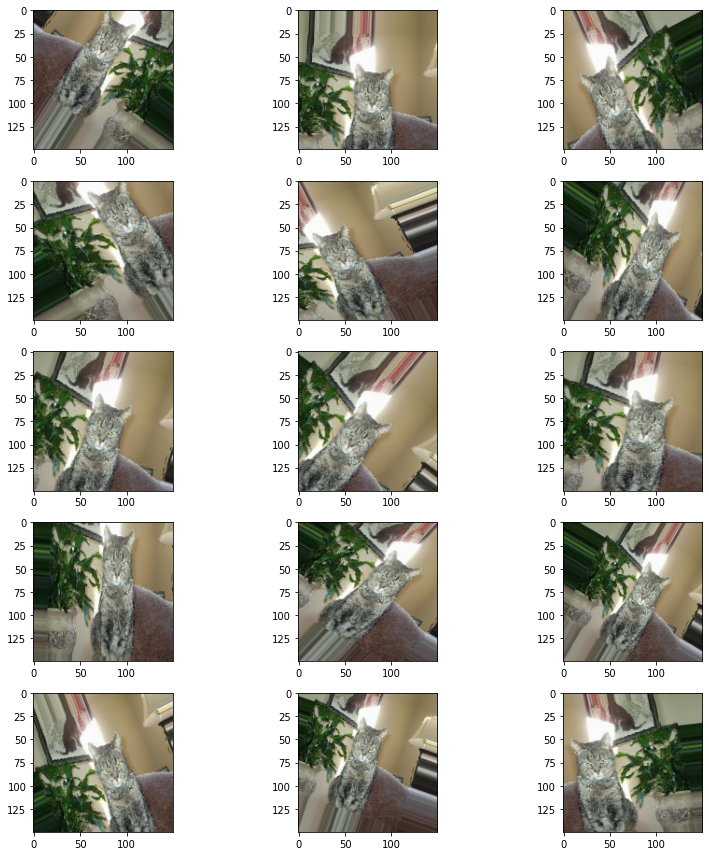

In [16]:
sample = random.choice(range(0,4999))

example_generator = train_datagen.flow(
    x_train_img[sample:sample+1],
    y_train_encoded[sample:sample+1],
    batch_size=1
)

plt.figure(figsize=(12, 12))
for i in range(0,15):
    plt.subplot(5, 3, i+1)
    for X,y in example_generator:
        image = X[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## 13. Model training

In [17]:
epochs = 2

"""history = model.fit(x_train_scaled, y_train_encoded, epochs=epochs, 
                    validation_data=(x_val_scaled, y_val_encoded), batch_size=512, 
                    callbacks=[callback_val_loss, callback_val_accuracy])"""

history = model.fit(train_generator, epochs=epochs, 
                    validation_data=validation_generator,
                    steps_per_epoch= 100, validation_steps=50,
                    callbacks=[callback_val_loss, callback_val_accuracy])

Epoch 1/2
100/100 [==============================] - 47s 467ms/step - loss: 0.7001 - accuracy: 0.5104 - val_loss: 0.6927 - val_accuracy: 0.5060
Epoch 2/2
100/100 [==============================] - 52s 523ms/step - loss: 0.6855 - accuracy: 0.5430 - val_loss: 0.6878 - val_accuracy: 0.5370


## 14. Save the model

In [18]:
model.save(path+"basic_model.h5")

## 15. Let's see the results

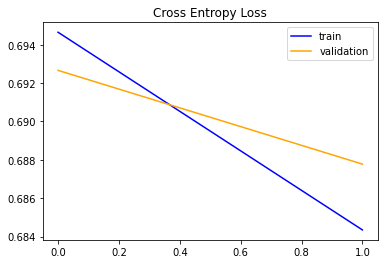

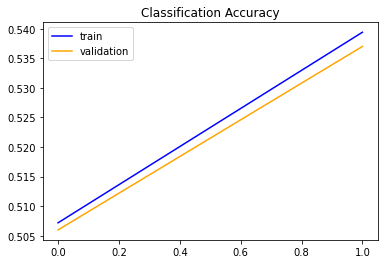

In [19]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.legend()
plt.show()

In [20]:
_, acc = model.evaluate(x_test_scaled, y_test_encoded, verbose=0)
print('Test accuracy of the model without data augmentation -> %.3f' % (acc * 100.0))

Test accuracy of the model without data augmentation -> 52.000


## 16. Lets see some predictions

In [21]:
predictions = model.predict(x_test_scaled) 


In [22]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    if true_label == 1:
        true_label = 'dog'
    else:
        true_label = 'cat'

    if np.max(predictions_array) > 0.50:
        predicted_label = 'dog'
    else:
        predicted_label = 'cat'

    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(1))
    plt.yticks([])

    if true_label == 1:
        true_label = 'dog'
    else:
        true_label = 'cat'

    if np.max(predictions_array) > 0.50:
        predicted_label = 'dog'
    else:
        predicted_label = 'cat'

    if predicted_label == true_label:
        color_plt = 'blue'
    else:
        color_plt = 'red'

    thisplot = plt.bar(range(1), np.max(predictions_array), color=color_plt)
    plt.ylim([0, 1])


We draw the first samples, with the predictions and their real values (a total of 20 images, so as not to abuse your laptops)

We color the correct predictions in blue and the failures in red

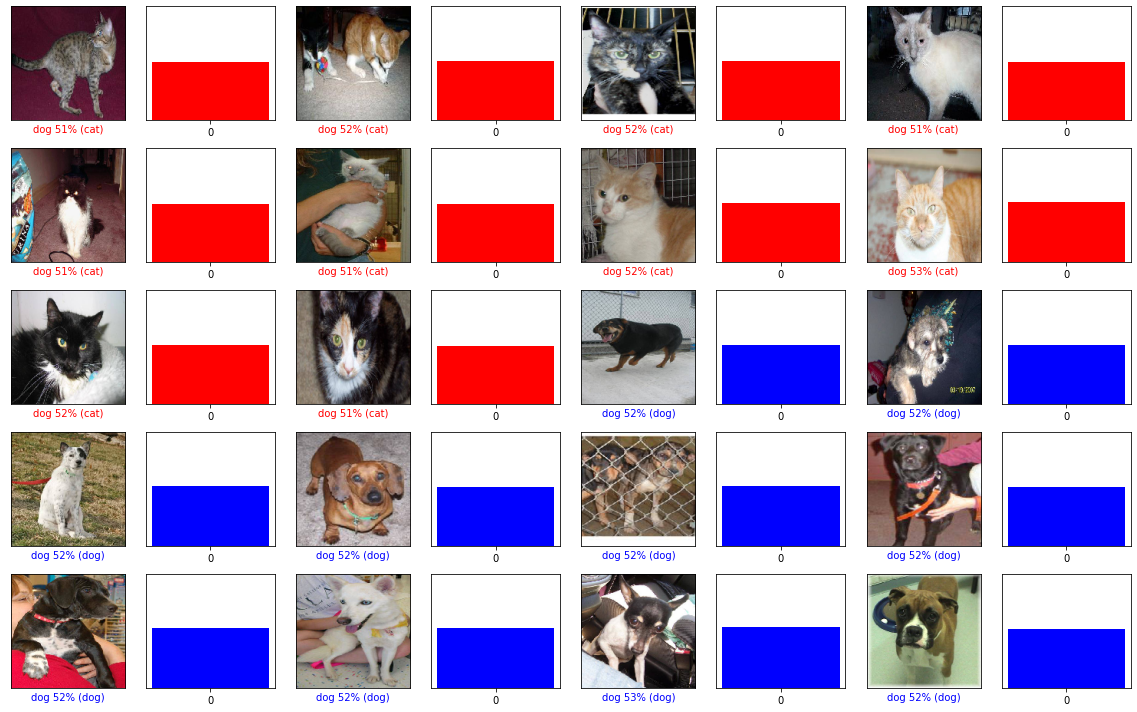

In [23]:
num_rows = 5
num_cols = 4
start = 490
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i+start, predictions[i+start], y_test_encoded, x_test_scaled)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i+start, predictions[i+start], y_test_encoded)
plt.tight_layout()
plt.show()